# Define different implementations of the geometry
many ways can be used to define the geometry. Geometry should include functions that can compute the normals, detect whether a point is on the surface or not, and sample points on the surface.
Ways to implement geometry:
- shape primitives
- point cloud
- grid
- convex hull

In [1]:
import numpy as np
import utilities as utils
import scipy.spatial as ss

In [2]:
class GridGeometry:
    """
    this geometry class uses pcd as input, and represents the shape by a grid.
    pcd: mean is (0,0)
    grid: center is the same as pcd's center
    """
    def __init__(self, pcd, grid, resols):
        self.pcd = pcd
        self.grid = grid
        self.resols = resols
        self.w = grid.shape[0] * resols[0]
        self.h = grid.shape[1] * resols[1]
        self.com = np.array([self.w/2, self.h/2])

        self.construct_surface()
    def construct_surface(self):
        # interior: grid that is not on the boundary, and has all neighbors filled
        grid = np.array(self.grid)
        grid_x, grid_y = np.indices(grid.shape)
        mask1 = (grid_x > 0) & (grid_x < grid.shape[0]-1) & (grid_y > 0) & (grid_y < grid.shape[1]-1)
        grid1 = grid[1:grid.shape[0]-1, 1:grid.shape[1]-1]
        for dx in [-1, 1]:
            grid_ = grid[1+dx:grid.shape[0]-1+dx, 1:grid.shape[1]-1]
            grid1 = grid1 & grid_
            grid_ = grid[1:grid.shape[0]-1, 1+dx:grid.shape[1]-1+dx]
            grid1 = grid1 & grid_
        grid_total = np.zeros(grid.shape).astype(bool)
        grid_total[1:grid.shape[0]-1, 1:grid.shape[1]-1] = grid1
        surface_grid = grid & (~grid_total)  # surface
        inter_grid = grid & (grid_total)
        
        # to determine if it's inside (-1) or outside (1)
        self.masked_grid = np.ones(grid.shape).astype(int)
        self.masked_grid[inter_grid] = -1
        self.masked_grid[surface_grid] = 0
        self.grid_grad = np.gradient(self.masked_grid)
        self.grid_grad = np.array(self.grid_grad).transpose([1,2,0])  # NxMx2
        
        # filter pcd
        pcd = self.pcd
        pcd_indices = pcd + self.com        
        pcd_indices = pcd_indices / self.resols

        pcd_indices = np.floor(pcd_indices).astype(int)
        mask = surface_grid[pcd_indices[:,0],pcd_indices[:,1]]
        pcd = pcd[mask]
        self.surface_pcd = np.array(pcd)
        
        # TODO: generate a KD-tree to later compute normals
        self.kd_tree = ss.KDTree(np.array(pcd), leafsize=10)
        # this can be used to project pt on the surface, since the "projection" is defined
        # to be the one with the shortest distance
        
        return grid
        
    def get_normal(self, p):
        # https://stackoverflow.com/questions/16195297/computing-normals-at-each-point-in-a-point-cloud
        # point cloud estimation of normal uses local region, and statistic fitting of the plane
        # the direction of the least variance is the normal direction
        # * here we use open3d to get the normal
        # find nearest pt in the pcd
        # p shape: B x 2
        dis, indices = self.kd_tree.query(p, k=1)
        indices = indices.reshape(-1)
        pt = self.kd_tree.data[indices] + self.com  # B x 2
        indices = pt / self.resols
        indices = np.floor(indices).astype(int)
        grad = self.grid_grad[indices[:,0], indices[:,1]]  # B x 2
        grad = grad / np.linalg.norm(grad, axis=1, keepdims=True)
        # pointing inward
        return -grad
    
    def sample_pt(self):
        # sample a random pt on the surface
        pt = np.random.choice(len(self.surface_pcd))
        pt = self.surface_pcd[pt]
        return pt
        


In [3]:
%matplotlib --list

# This is non-interactive: it shows static plots inline
# %matplotlib inline

# This is interactive: it shows dynamic plots in the notebook
%matplotlib notebook

# This is interactive: it shows dynamic plots in separate GUI windows
# %matplotlib tk

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [4]:
import matplotlib.pyplot as plt
def vis_test1():
    # visualize the geometry

    # pcd: circle
    # https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly
    r = np.random.uniform(size=(5000,1))
    r = np.sqrt(r)
    pt = np.random.normal(size=(5000,2))
    pt = pt / np.linalg.norm(pt, axis=1, keepdims=True)
    pcd = r * pt
    resols = np.array([0.1, 0.1])
    pcd, grid = utils.pcd_to_grid(pcd, resols)
    grid_geometry = GridGeometry(pcd, grid, resols)

    plt.figure()
    plt.imshow(grid_geometry.masked_grid, origin='lower', 
               extent=(0, grid_geometry.masked_grid.shape[1], 0, grid_geometry.masked_grid.shape[1]))
    plt.show()

    plt.figure()
    plt.imshow(grid_geometry.masked_grid, origin='lower', 
               extent=(0, grid_geometry.masked_grid.shape[1], 0, grid_geometry.masked_grid.shape[1]))
    surface_pcd = grid_geometry.surface_pcd
    surface_pcd = surface_pcd + np.array([grid_geometry.w/2, grid_geometry.h/2]) # shift the center to mean of grid
    surface_pcd = surface_pcd/grid_geometry.resols
    plt.scatter(surface_pcd[:,0], surface_pcd[:,1])
    plt.show()

    plt.figure()
    plt.imshow(grid_geometry.masked_grid, origin='lower', 
               extent=(0, grid_geometry.masked_grid.shape[1], 0, grid_geometry.masked_grid.shape[1]))
    grid_x, grid_y = np.indices(grid_geometry.grid.shape)
    for i in range(len(grid_geometry.grid_grad)):
        for j in range(grid_geometry.grid_grad.shape[1]):
            normal = grid_geometry.grid_grad[i,j]
            normal = normal / np.linalg.norm(normal) * 2
            plt.arrow(grid_x[i,j]+0.5,grid_y[i,j]+0.5,
                      grid_geometry.grid_grad[i,j,0], grid_geometry.grid_grad[i,j,1], width=0.1,
                      color='red')        

    plt.show()

    plt.figure()
    plt.imshow(grid_geometry.masked_grid, origin='lower', 
               extent=(0, grid_geometry.masked_grid.shape[1], 0, grid_geometry.masked_grid.shape[1]))

    normals = grid_geometry.get_normal(grid_geometry.surface_pcd)
    normals = normals / np.linalg.norm(normals, axis=1, keepdims=True)
    normals = normals * 2
    surface_pcd = grid_geometry.surface_pcd
    surface_pcd = surface_pcd + np.array([grid_geometry.w/2, grid_geometry.h/2]) # shift the center to mean of grid
    surface_pcd = surface_pcd/grid_geometry.resols

    plt.scatter(surface_pcd[:,0], surface_pcd[:,1])
    for i in range(len(normals)):
        plt.arrow(surface_pcd[i,0],surface_pcd[i,1],
                  normals[i,0], normals[i,1], width=0.1, color='red')

    plt.show()


<IPython.core.display.Javascript object>


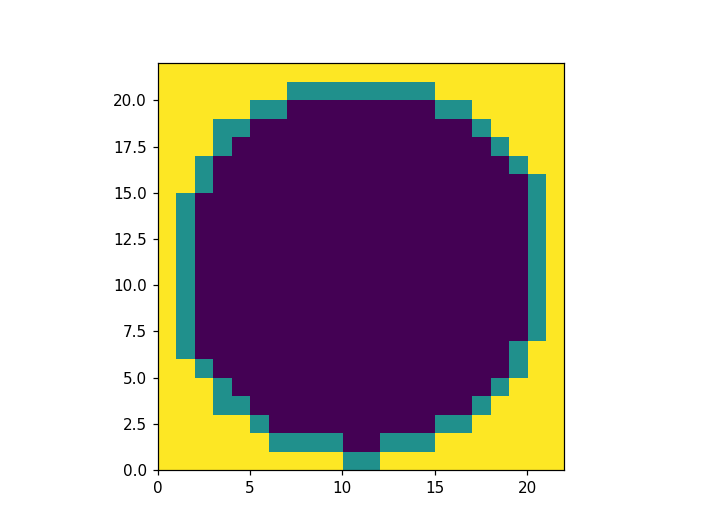

<IPython.core.display.Javascript object>


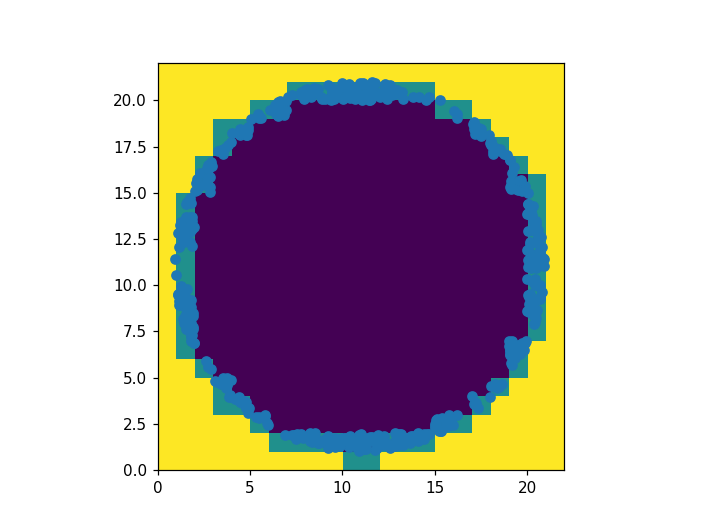

<IPython.core.display.Javascript object>


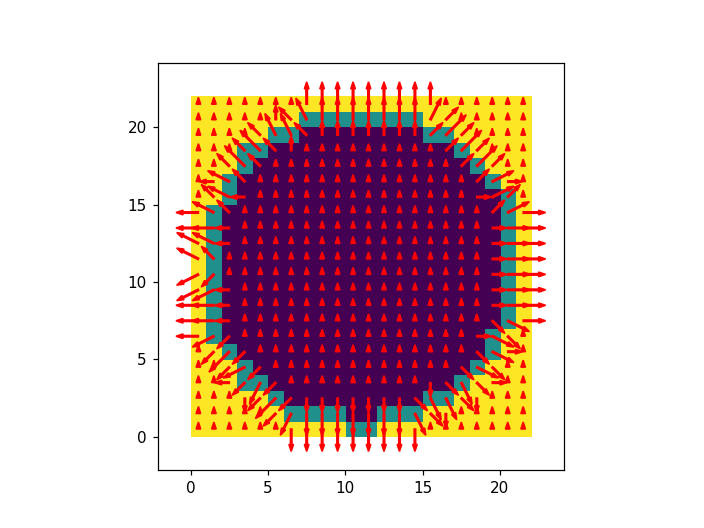

<ipython-input-4-d6c8fd64c4c7>:37: RuntimeWarning: invalid value encountered in divide
  normal = normal / np.linalg.norm(normal) * 2


<IPython.core.display.Javascript object>


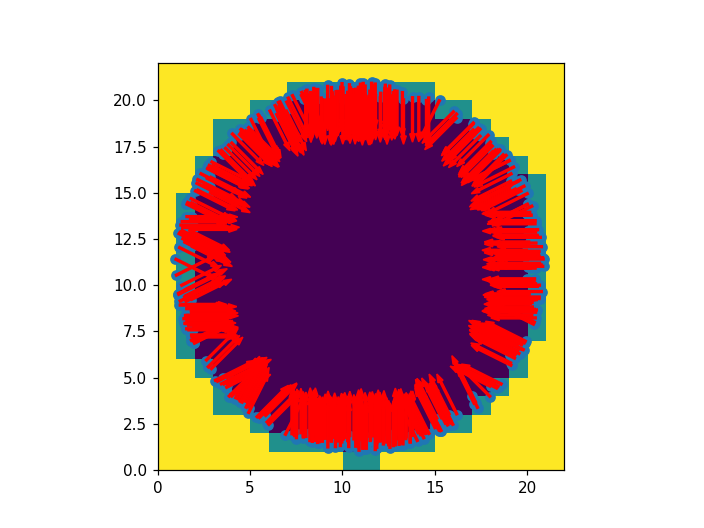

In [5]:
vis_test1()